<a href="https://colab.research.google.com/github/tomonari-masada/course2021-sml/blob/main/07_linear_regression_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 重回帰による住宅価格の予測

* California housing datasetという有名なデータセットを使う。

 * scikit-learnからロードできるバージョンは、前処理が済んだキレイなデータなので、ここでは使わない。

* データの取得や前処理の一部は、
[Aurélien Géron. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition.](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) の2章と同じ。

* 機械学習において線形回帰モデルを使うときは、予測性能が最重要
 * 予測性能が上がるなら何でもする、という考え方。

In [1]:
import numpy as np
from scipy import stats, special
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%config InlineBackend.figure_format = 'retina'

### 1) データを取得

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  os.makedirs(housing_path, exist_ok=True)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

（ここより上の詳細はフォローしなくてもいいいです。）

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 2) データを概観しつつ前処理

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


* 数値データではない列が一つだけある

In [7]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

* この数値データではない列を消してしまう
 * ここを変更してもいいです。

In [8]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [9]:
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


* Non-Null Countが他より少ない列がある
  * ここでは単に削除することにする（ここを変更してもいいです）。

In [10]:
housing_num = housing_num.dropna(subset=['total_bedrooms'])

In [11]:
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
dtypes: float64(9)
memory usage: 1.6 MB


* 説明変数と目的変数を分ける
 * median_house_valueを予測する、という問題設定。

In [12]:
X = housing_num.drop('median_house_value', axis=1)
y = housing_num["median_house_value"].copy()

### 3) 評価実験のための準備

* 訓練データ、検証データ、テストデータに分ける

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [14]:
print(X_train.shape, X_valid.shape, X_test.shape)

(13076, 8) (3270, 8) (4087, 8)


* 交差検証をしてもらってもいいです。

### 4) 訓練データをよくよくながめてみる

* ヒストグラムを描く
 * cf. Aurélien Géron. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition. p.50

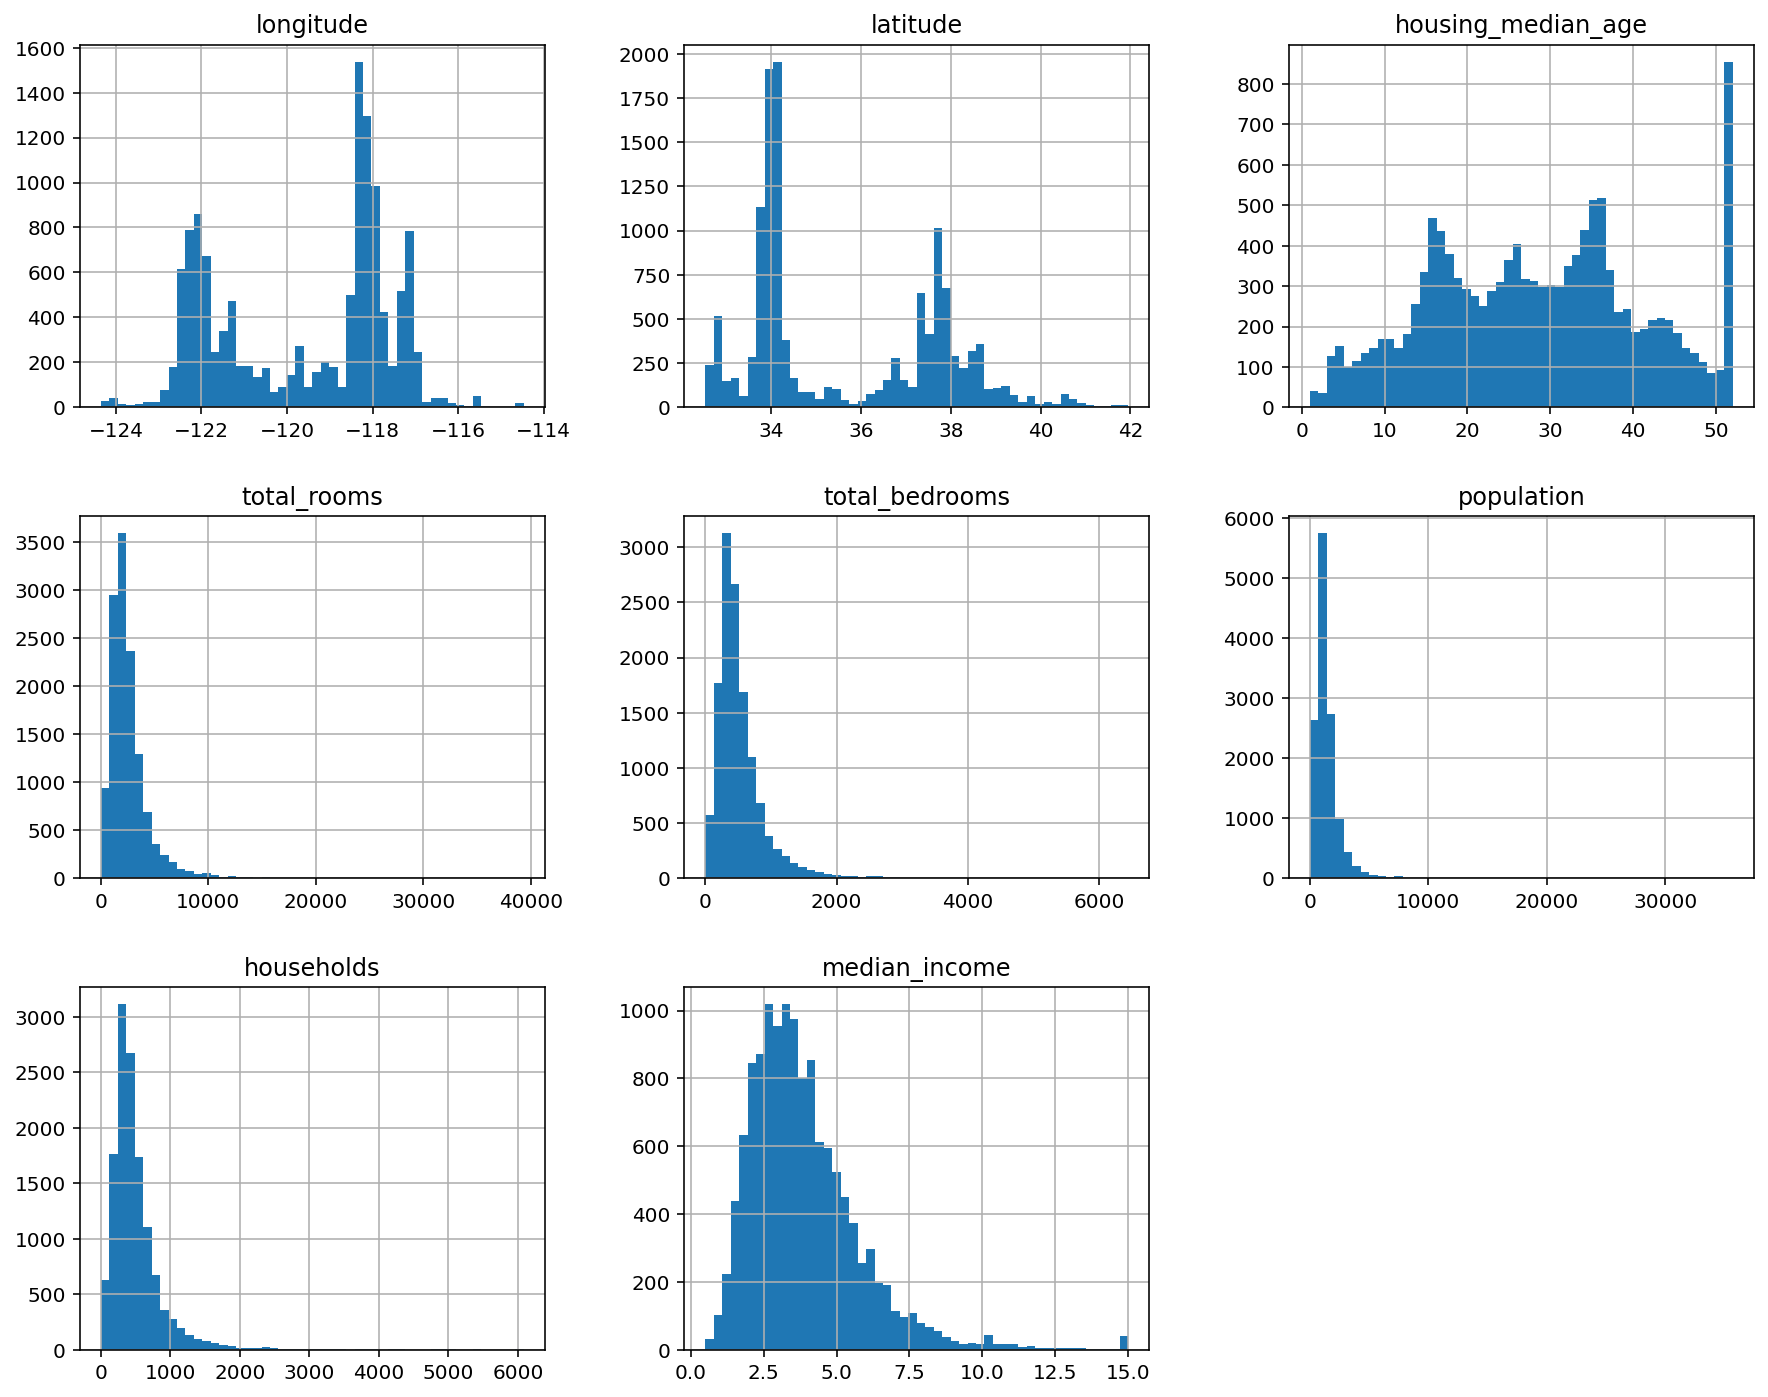

In [15]:
X_train.hist(bins=50, figsize=(15,12))
plt.show()

In [16]:
X_train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,13076.000000,13076.000000,13076.000000,13076.000000,13076.000000,13076.000000,13076.000000,13076.000000
mean,-119.580858,35.637584,28.594524,2620.400964,534.183695,1414.228357,495.663582,3.873914
std,2.005564,2.134201,12.614715,2140.791260,413.751652,1131.432407,375.041742,1.912762
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.820000,33.930000,18.000000,1452.000000,296.000000,788.000000,279.000000,2.560825
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1163.000000,407.000000,3.534850
75%,-118.010000,37.720000,37.000000,3124.000000,644.000000,1708.000000,601.000000,4.760900
max,-114.470000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100


* total_roomsの値の分布に注目してみる

(array([9.390e+02, 2.947e+03, 3.594e+03, 2.373e+03, 1.299e+03, 6.930e+02,
        3.590e+02, 2.490e+02, 1.710e+02, 1.020e+02, 7.600e+01, 5.000e+01,
        5.200e+01, 3.900e+01, 1.800e+01, 2.100e+01, 1.500e+01, 1.100e+01,
        7.000e+00, 1.500e+01, 8.000e+00, 4.000e+00, 7.000e+00, 6.000e+00,
        5.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([2.000000e+00, 7.883600e+02, 1.574720e+03, 2.361080e+03,
        3.147440e+03, 3.933800e+03, 4.720160e+03, 5.506520e+03,
        6.292880e+03, 7.079240e+03, 7.865600e+03, 8.651960e+03,
        9.438320e+03, 1.022468e+04, 1.101104e+04, 1.179740e+04,
        1.258376e+04, 1.337012e+04, 1.415648e+04, 1.494284e+04,
        1.572920e+04, 1.651556e+04, 1.730192e+04, 1.8088

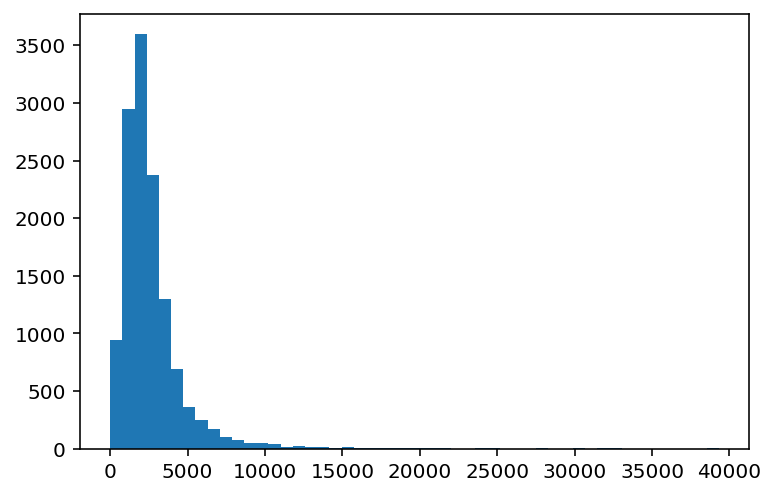

In [17]:
plt.hist(X_train.total_rooms, bins=50)

* 説明変数の値がどのように分布するかは、回帰モデルの予測性能に直接は関係しない。
 * 回帰モデルでは、誤差項が正規分布に従うという仮定はする。
 * しかし、説明変数の値の分布については、何も仮定しない。
  * 例えば、0か1かの2通りの値しかとらない説明変数もよく使う。
 * とはいえ、それで予測性能が上がるなら、説明変数の値の分布を変更してみる余地はある。

* total_roomsについて、scikit-learnのBox-Cox変換を適用して、ヒストグラムを描いてみる

0.2334280558920365


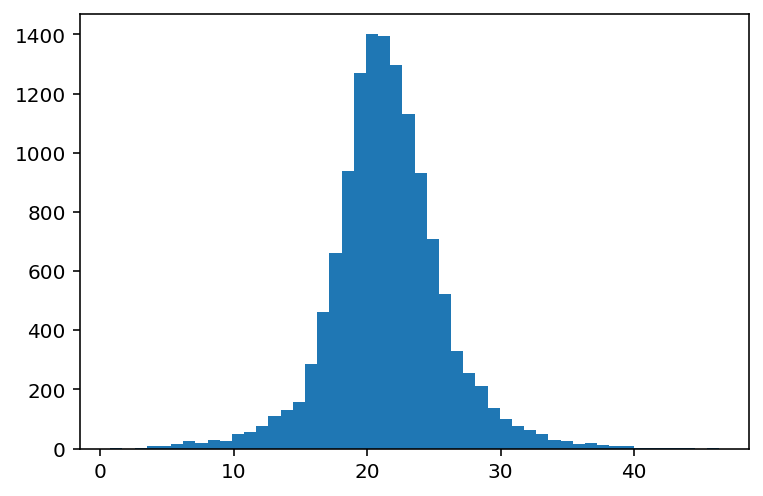

In [18]:
boxcox_, maxlog_ = stats.boxcox(X_train.total_rooms)
plt.hist(boxcox_, bins=50)
print(maxlog_)
# （maxlog_ の部分は、test setなど、別のデータ集合を同じ条件で変換するときに使う。）

* Box-Cox変換の戻し方

(array([9.390e+02, 2.947e+03, 3.594e+03, 2.373e+03, 1.299e+03, 6.930e+02,
        3.590e+02, 2.490e+02, 1.710e+02, 1.020e+02, 7.600e+01, 5.000e+01,
        5.200e+01, 3.900e+01, 1.800e+01, 2.100e+01, 1.500e+01, 1.100e+01,
        7.000e+00, 1.500e+01, 8.000e+00, 4.000e+00, 7.000e+00, 6.000e+00,
        5.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([2.000000e+00, 7.883600e+02, 1.574720e+03, 2.361080e+03,
        3.147440e+03, 3.933800e+03, 4.720160e+03, 5.506520e+03,
        6.292880e+03, 7.079240e+03, 7.865600e+03, 8.651960e+03,
        9.438320e+03, 1.022468e+04, 1.101104e+04, 1.179740e+04,
        1.258376e+04, 1.337012e+04, 1.415648e+04, 1.494284e+04,
        1.572920e+04, 1.651556e+04, 1.730192e+04, 1.8088

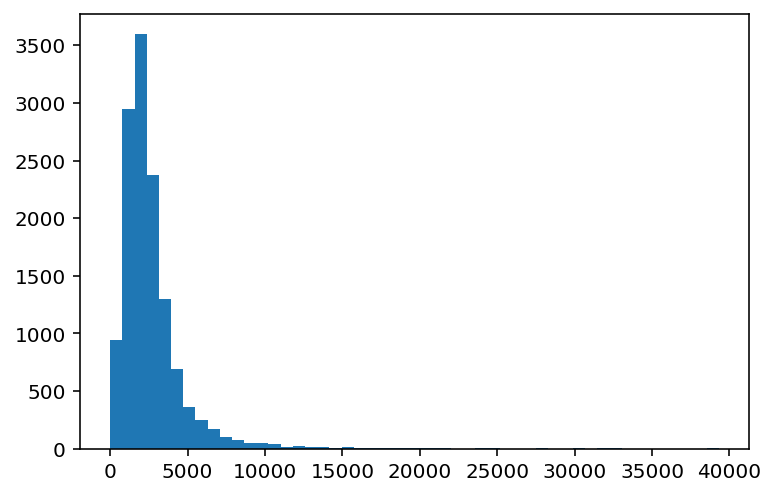

In [19]:
plt.hist(special.inv_boxcox(boxcox_, maxlog_), bins=50)

* 変換した後のデータを使うほうが予測性能がよくなるかどうか、後で試してみよう。

* housing_median_ageを見てみる
 * 最大値の頻度が妙に高い。

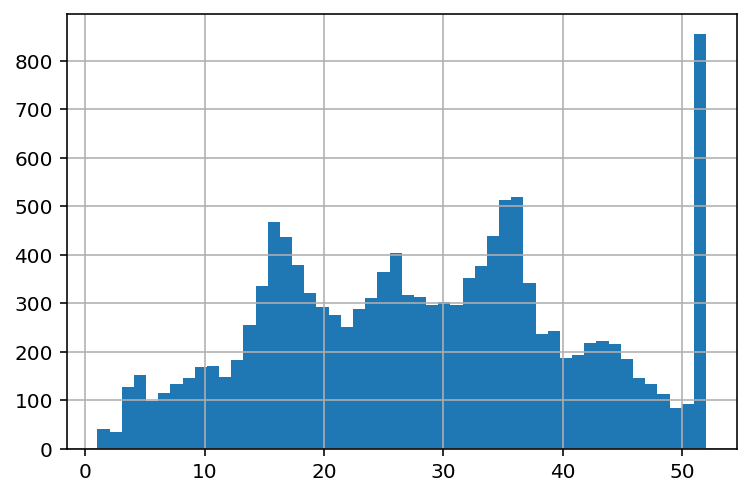

In [20]:
X_train.housing_median_age.hist(bins=50)

In [21]:
X_train.housing_median_age.value_counts().head()

52.0    824
36.0    518
35.0    513
16.0    468
34.0    439
Name: housing_median_age, dtype: int64

* 目的変数の値の分布

* 相関係数のヒートマップ
 * 多重共線性 https://bellcurve.jp/statistics/glossary/1792.html

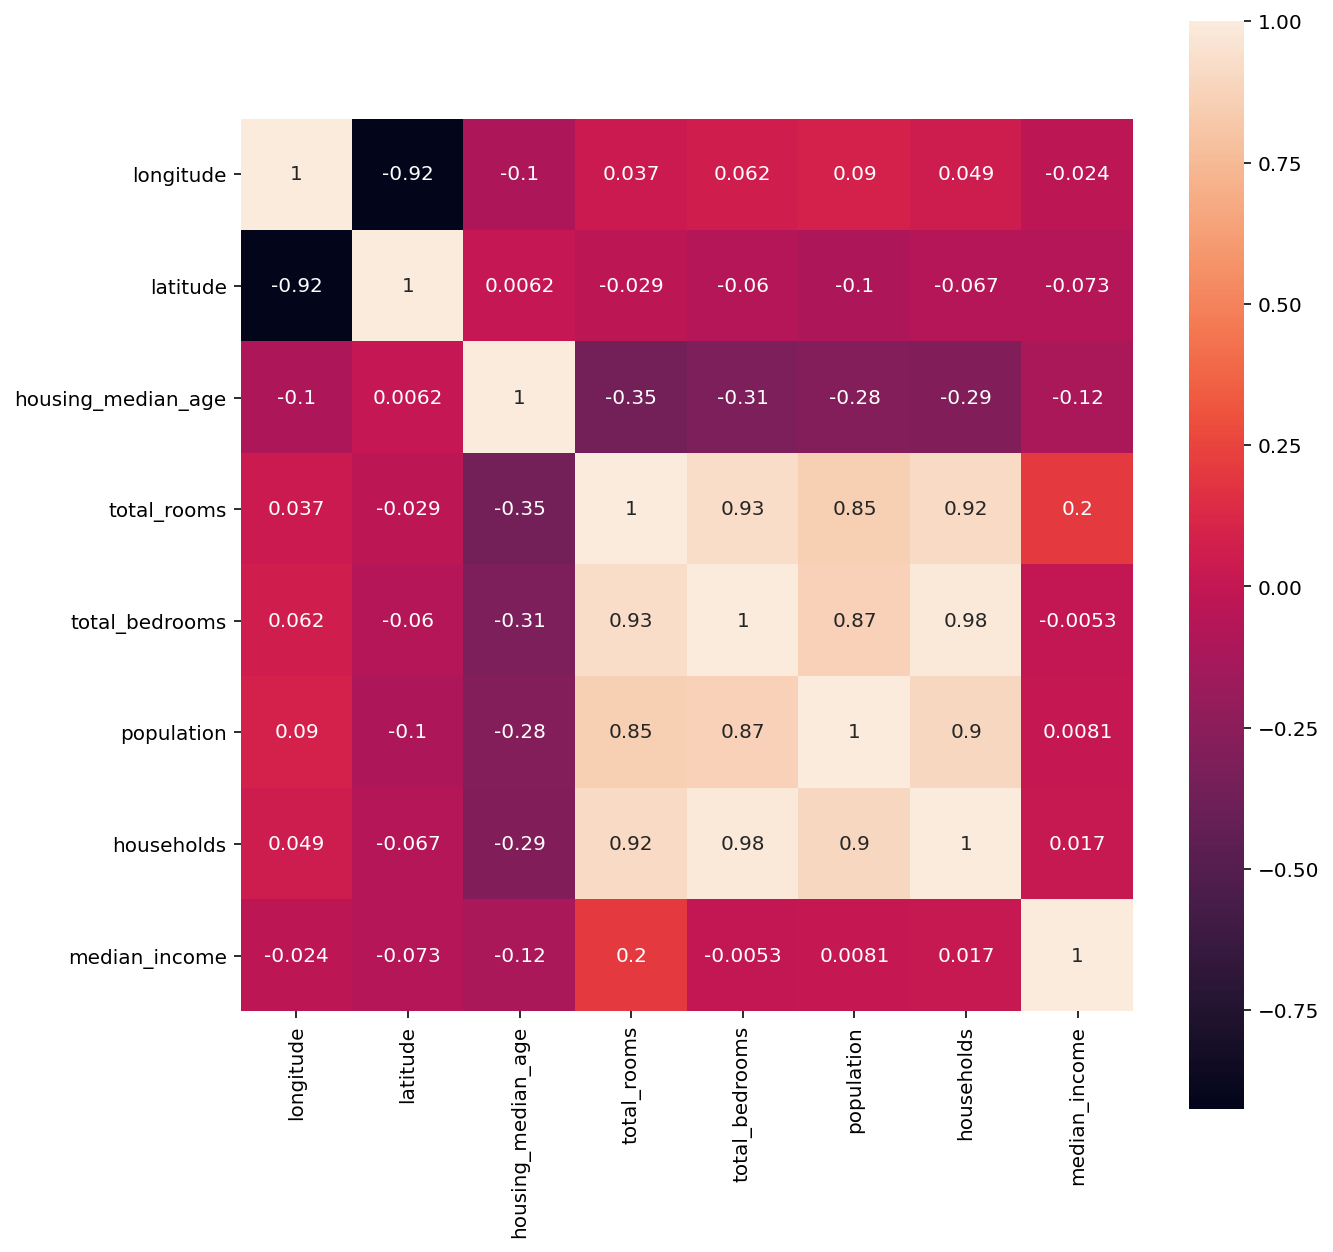

In [22]:
plt.subplots(figsize=(10,10))
sns.heatmap(X_train.corr(), annot=True, square=True)

* pair plot

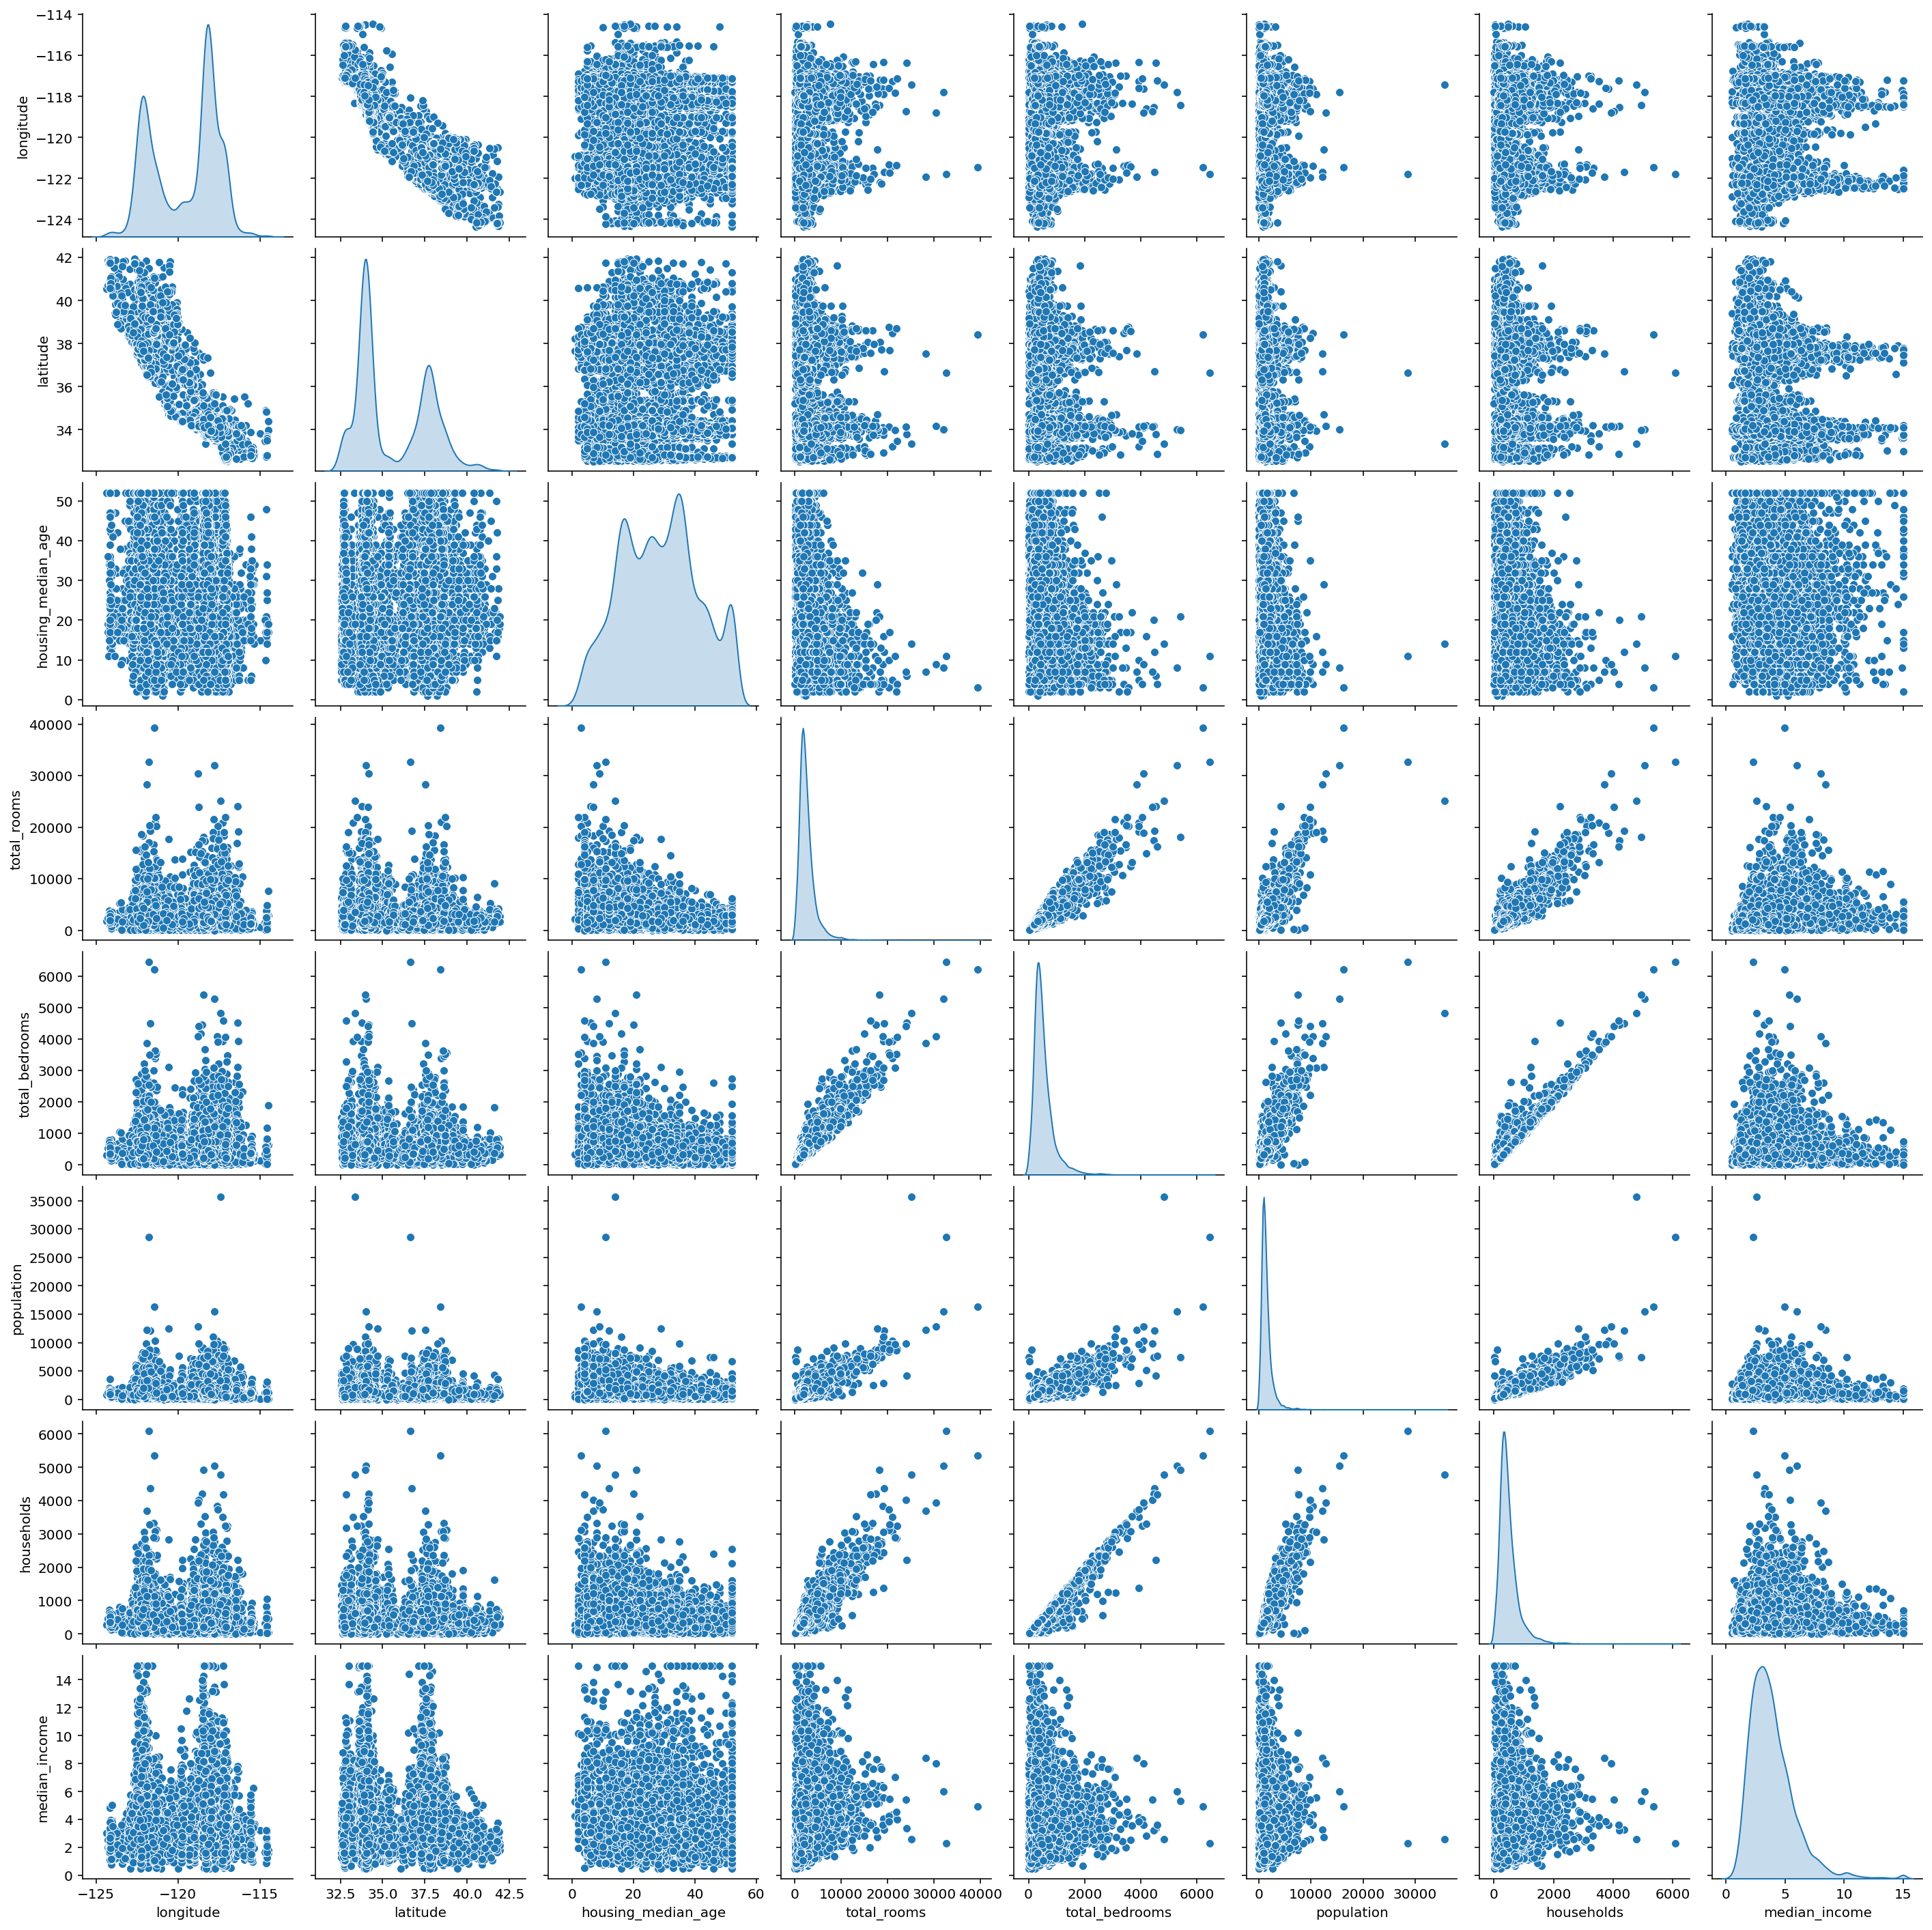

In [23]:
sns.pairplot(X_train, diag_kind='kde')

### 5) 線形回帰

* training set上でモデル・パラメータを決定する


In [24]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

* validation set上で評価する


In [25]:
y_valid_pred = reg.predict(X_valid)
rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
print(f'RMSE: {rmse:f}')

RMSE: 67667.758078


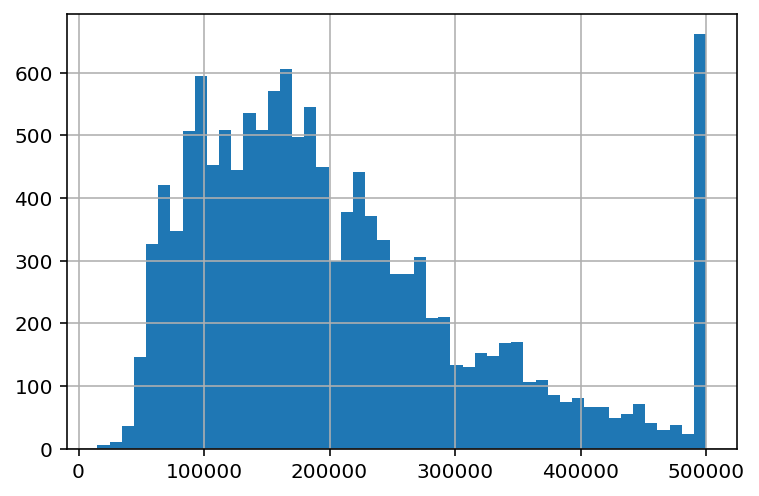

In [26]:
y_train.hist(bins=50)

In [27]:
y_train.value_counts().head()

500001.0    624
137500.0     80
162500.0     76
112500.0     66
187500.0     61
Name: median_house_value, dtype: int64

In [28]:
y_valid_pred = reg.predict(X_valid)
y_valid_pred[y_valid_pred > y_train.max()] = y_train.max()
rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
print(f'RMSE: {rmse:f}')

RMSE: 67159.543570


## 6) リッジ回帰
* 係数の二乗の和を抑える正則化を含む。

In [29]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=1.0)
reg.fit(X_train, y_train)
y_valid_pred = reg.predict(X_valid)
y_valid_pred[y_valid_pred > y_train.max()] = y_train.max()
print('RMSE: {:f}'.format(mean_squared_error(y_valid, y_valid_pred, squared=False)))

RMSE: 67159.809844


## 7) Lasso
* 係数の絶対値の和を抑える正則化を含む。

In [30]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=1.0)
reg.fit(X_train, y_train)
y_valid_pred = reg.predict(X_valid)
y_valid_pred[y_valid_pred > y_train.max()] = y_train.max()
print('RMSE: {:f}'.format(mean_squared_error(y_valid, y_valid_pred, squared=False)))

RMSE: 67159.629562


## 8) 試行錯誤するための選択肢

### 説明変数の値を加工
 * Box-Cox変換（既述）
 * MinMaxScaler

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train) # スケーラのfitは訓練データのみで行う
X_train_scaled = X_train.copy()
X_train_scaled[X_train.columns] = scaler.transform(X_train)
X_valid_scaled = X_valid.copy()
X_valid_scaled[X_valid.columns] = scaler.transform(X_valid) # 検証データに同じスケーリングを適用

In [32]:
X_train_scaled.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,13076.000000,13076.000000,13076.000000,13076.000000,13076.000000,13076.000000,13076.000000,13076.000000
mean,0.482707,0.329180,0.541069,0.066595,0.082741,0.039553,0.081346,0.232687
std,0.202992,0.226801,0.247347,0.054448,0.064207,0.031711,0.061674,0.131913
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.256073,0.147715,0.333333,0.036879,0.045779,0.022002,0.045716,0.142131
50%,0.591093,0.182784,0.549020,0.053843,0.067039,0.032512,0.066765,0.209304
75%,0.641700,0.550478,0.705882,0.079404,0.099783,0.047787,0.098668,0.293858
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 正則化パラメータをチューニング

In [33]:
for alpha in 10. ** np.arange(-6, 7):
  reg = Ridge(alpha=alpha, random_state=123)
  reg.fit(X_train_scaled, y_train)
  y_valid_pred = reg.predict(X_valid_scaled)
  y_valid_pred[y_valid_pred > y_train.max()] = y_train.max()
  rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
  print(f'alpha: {alpha:f}; RMSE: {rmse:f}')

alpha: 0.000001; RMSE: 67159.544071
alpha: 0.000010; RMSE: 67159.548577
alpha: 0.000100; RMSE: 67159.593649
alpha: 0.001000; RMSE: 67160.044618
alpha: 0.010000; RMSE: 67164.579587
alpha: 0.100000; RMSE: 67212.191927
alpha: 1.000000; RMSE: 67768.452641
alpha: 10.000000; RMSE: 70608.285183
alpha: 100.000000; RMSE: 79305.965735
alpha: 1000.000000; RMSE: 102995.502044
alpha: 10000.000000; RMSE: 112706.027637
alpha: 100000.000000; RMSE: 113979.114161
alpha: 1000000.000000; RMSE: 114110.677290


In [34]:
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)
y_valid_pred = reg.predict(X_valid_scaled)
y_valid_pred[y_valid_pred > y_train.max()] = y_train.max()
rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
print(f'RMSE: {rmse:f}')

RMSE: 67159.543570


### 新しい説明変数を作成

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [36]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
5724,-118.26,34.18,32.0,14556.0,2077.0,5459.0,2017.0,8.1657
7491,-118.23,33.92,32.0,2698.0,640.0,1953.0,613.0,1.2222
18036,-121.91,37.23,22.0,2614.0,453.0,1240.0,462.0,6.0712
2047,-119.72,36.72,15.0,1713.0,246.0,766.0,232.0,6.8162
16145,-122.47,37.78,52.0,2169.0,522.0,1220.0,505.0,3.1989


In [37]:
print(X_train.longitude.median(), X_train.latitude.median())

-118.51 34.26


In [38]:
med_lon = X_train.longitude.median()
med_lat = X_train.latitude.median()

In [39]:
flag_lon = (X_train.longitude < med_lon) * 1
flag_lat = (X_train.latitude < med_lat) * 1

X_train['lon'] = flag_lon
X_train['lat'] = flag_lat

In [40]:
X_train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,lon,lat
count,13076.000000,13076.000000,13076.000000,13076.000000,13076.000000,13076.000000,13076.000000,13076.000000,13076.000000,13076.000000
mean,-119.580858,35.637584,28.594524,2620.400964,534.183695,1414.228357,495.663582,3.873914,0.498929,0.497629
std,2.005564,2.134201,12.614715,2140.791260,413.751652,1131.432407,375.041742,1.912762,0.500018,0.500013
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,0.000000,0.000000
25%,-121.820000,33.930000,18.000000,1452.000000,296.000000,788.000000,279.000000,2.560825,0.000000,0.000000
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1163.000000,407.000000,3.534850,0.000000,0.000000
75%,-118.010000,37.720000,37.000000,3124.000000,644.000000,1708.000000,601.000000,4.760900,1.000000,1.000000
max,-114.470000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,1.000000,1.000000


In [41]:
flag_lon = (X_valid.longitude < med_lon) * 1
flag_lat = (X_valid.latitude < med_lat) * 1

X_valid['lon'] = flag_lon
X_valid['lat'] = flag_lat

In [42]:
scaler = MinMaxScaler()
scaler.fit(X_train) # スケーラのfitは訓練データのみで行う
X_train_scaled = X_train.copy()
X_train_scaled[X_train.columns] = scaler.transform(X_train)
X_valid_scaled = X_valid.copy()
X_valid_scaled[X_valid.columns] = scaler.transform(X_valid) # 検証データに同じスケーリングを適用

In [43]:
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)
y_valid_pred = reg.predict(X_valid_scaled)
y_valid_pred[y_valid_pred > y_train.max()] = y_train.max()
rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
print(f'RMSE: {rmse:f}')

RMSE: 66328.281211


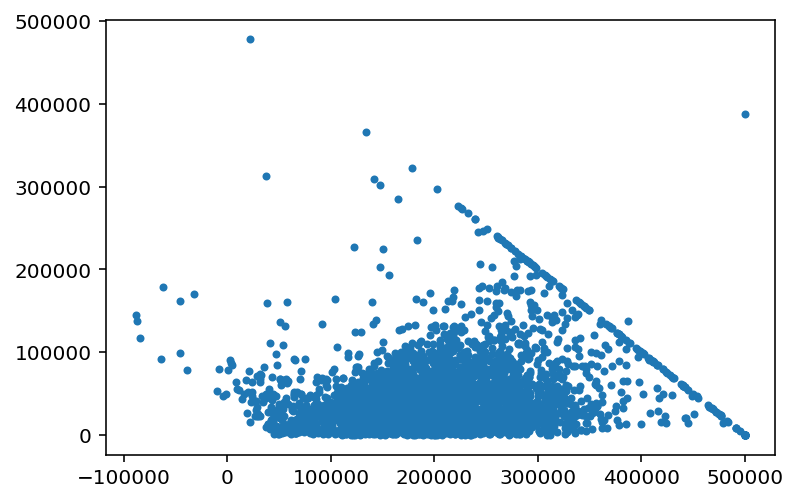

In [44]:
plt.plot(y_valid_pred, np.abs(y_valid_pred - y_valid), '.')

# 課題7

* RMSEによって評価される予測性能を、良くして下さい
* test setとそれ以外の部分の分割は、変えないでください
 * test set以外の部分をどう使うかは、自由です。
 * 交差検証をしていいです。
* リッジ回帰とLassoを使ってもいいです
* 高次多項式特徴量を使ってもいいです（sklearn.preprocessing.PolynomialFeatures）
* test setでのRMSEによる評価は最後に一回おこなうだけです